<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/210302_bus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
colab_path =  '/content/gdrive/MyDrive/final/'

Mounted at /content/gdrive/


In [ ]:
# !pip install geojson

In [ ]:
# !pip install rtree
# !pip install geopandas
# !pip3 install folium

In [ ]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlt
import geopandas as gpd
import folium
import shapely

from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost
import sklearn.cluster
import tensorflow as tf

In [ ]:
#Pydeck 사용을 위한 함수 정의
import geopandas as gpd 
import shapely # Shapely 형태의 데이터를 받아 내부 좌표들을 List안에 반환합니다. 
def line_string_to_coordinates(line_string): 
    if isinstance(line_string, shapely.geometry.linestring.LineString): 
        lon, lat = line_string.xy 
        return [[x, y] for x, y in zip(lon, lat)] 
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString): 
        ret = [] 
        for i in range(len(line_string)): 
            lon, lat = line_string[i].xy 
            for x, y in zip(lon, lat): 
                ret.append([x, y])
        return ret 

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

In [ ]:
교통노드 = gpd.read_file(colab_path + '20.수원시_교통노드.geojson')
교통노드.head()
# ODE_ID    노드 ID값 
# NODE_TYPE    노드의 유형코드 번호
# NODE_NAME    노드의 이름
# TURN_P    회전제한유무 코드
# REMARK    노드관련 비고

NODE_ID NODE_TYPE  ... REMARK                         geometry
0  2000001700       101  ...      -  MULTIPOINT (126.98821 37.31794)
1  2000001500       101  ...      -  MULTIPOINT (126.98977 37.31183)
2  2000001300       101  ...      -  MULTIPOINT (126.99566 37.30880)
3  2000001200       103  ...      -  MULTIPOINT (126.99790 37.30782)
4  2000001000       101  ...      -  MULTIPOINT (127.00208 37.30596)

[5 rows x 6 columns]

In [ ]:
# geometry를 coordinate 형태로 적용
교통노드['geometry'] = 교통노드['geometry'].apply(multipoint_to_coordinates)

# 100X100 grid에서 central point 찾기
교통노드_list = []
교통노드_list2 = []
for i in 교통노드['geometry']:
    cent = [[i[0].centroid.coords[0][0],i[0].centroid.coords[0][1]]]
    교통노드_list.append(cent)
    교통노드_list2.append(Point(cent[0]))
교통노드['coord_cent'] = 0
교통노드['geo_cent'] = 0
교통노드['coord_cent']= pd.DataFrame(교통노드_list) # pydeck을 위한 coordinate type
교통노드['geo_cent'] = 교통노드_list2 # geopandas를 위한 geometry type

NameError: ignored

In [ ]:
교통노드.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   NODE_ID    1003 non-null   object  
 1   NODE_TYPE  1003 non-null   object  
 2   NODE_NAME  1003 non-null   object  
 3   TURN_P     1003 non-null   object  
 4   REMARK     694 non-null    object  
 5   geometry   1003 non-null   geometry
dtypes: geometry(1), object(5)
memory usage: 47.1+ KB


In [ ]:
교통링크 = gpd.read_file(colab_path + '21.수원시_교통링크.geojson')
교통링크.head()
#LINK_ID    링크를 식별하기 위한 ID
# F_NODE    시작노드의 ID
# T_NODE    종료노드의 ID
# ROAD_USE    도로사용여부 코드
# LANES    해당 링크의 차로수 
# ROAD_RANK    해당 링크의 도로등급코드 
# ROAD_NAME    해당 링크의 도로명
# MULTI_LINK    해당 링크의 중용구간 여부(0:독립구간/1:중용구간)
# CONNECT    해당 링크의 연결로코드
# MAX_SPD    해당 링크의 최고제한속도
# REST_VEH    해당 링크의 통행제한차량코드 
# REST_W    해당 링크의 통과제한하중 
# REST_H    해당 링크의 통과제한높이 
# REMARK    해당 링크의 비고
# ROAD_TYPE    도로의 유형
# ROAD_NO    도로의 번호

LINK_ID  ...                                           geometry
0  2260058800  ...  MULTILINESTRING ((126.96189 37.30239, 126.9623...
1  2260058700  ...  MULTILINESTRING ((126.96238 37.30224, 126.9620...
2  2020005104  ...  MULTILINESTRING ((127.02494 37.28944, 127.0247...
3  2020005102  ...  MULTILINESTRING ((127.02417 37.28771, 127.0241...
4  2020005101  ...  MULTILINESTRING ((127.02147 37.28344, 127.0221...

[5 rows x 17 columns]

In [ ]:
교통링크['geometry'] = 교통링크['geometry'].apply(line_string_to_coordinates)
교통링크.head()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


LINK_ID  ...                                           geometry
0  2260058800  ...  [[126.96189145923577, 37.30238803236395], [126...
1  2260058700  ...  [[126.96238140350867, 37.30224143800985], [126...
2  2020005104  ...  [[127.02494418434263, 37.28944427018156], [127...
3  2020005102  ...  [[127.0241700003899, 37.28770536631607], [127....
4  2020005101  ...  [[127.02147429762914, 37.28343816414357], [127...

[5 rows x 17 columns]

In [ ]:
인도 = gpd.read_file(colab_path + '26.수원시_인도(2017).geojson')
인도.head()

UFID  ...                                           geometry
0  1000037612070A00310000000000154767  ...  MULTILINESTRING ((126.98492 37.32861, 126.9849...
1  1000037612070A00310000000000154768  ...  MULTILINESTRING ((126.98567 37.32644, 126.9857...
2  1000037612070A00310000000000154769  ...  MULTILINESTRING ((126.98459 37.32839, 126.9849...
3  1000037612070A00310000000000154793  ...  MULTILINESTRING ((126.98565 37.32643, 126.9856...
4  1000037612070A00310000000000154794  ...  MULTILINESTRING ((126.98461 37.32840, 126.9847...

[5 rows x 6 columns]

In [ ]:
인도['geometry'] = 인도['geometry'].apply(line_string_to_coordinates)
인도

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


UFID  ...                                           geometry
0     1000037612070A00310000000000154767  ...  [[126.98492477104054, 37.32861429173025], [126...
1     1000037612070A00310000000000154768  ...  [[126.98567135163154, 37.32643671936139], [126...
2     1000037612070A00310000000000154769  ...  [[126.98458621654031, 37.32839471386689], [126...
3     1000037612070A00310000000000154793  ...  [[126.98565272370675, 37.326431994479215], [12...
4     1000037612070A00310000000000154794  ...  [[126.98460747532971, 37.32840442338037], [126...
...                                  ...  ...                                                ...
6645  1000037709083A00310000070000005528  ...  [[127.05005409016246, 37.29484563296847], [127...
6646  1000037709083A00310000070000005529  ...  [[127.06877844420707, 37.29512722114167], [127...
6647  1000037713001A00310000070000005753  ...  [[127.02219103714175, 37.23603040774282], [127...
6648  1000037713002A00310000070000005754  ...  [[127.04468834647113, 37.246725809611824], [12...
6649  1000037612098A00310000070000005765  ...  [[126.94321143340107, 37.27294575506401], [126...

[6650 rows x 6 columns]

In [ ]:
인도.info()
#UFID    인도별 고유 코드
# WIDT    인도의 폭 
# QUAL    인도의 재질을 나타내는 코드
# BYYN    자전거도로의 유무
# KIND    도로의 종류에 대한 정보

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   UFID      6650 non-null   object 
 1   WIDT      6650 non-null   float64
 2   QUAL      6650 non-null   object 
 3   BYYN      6650 non-null   object 
 4   KIND      6650 non-null   object 
 5   geometry  6650 non-null   object 
dtypes: float64(1), object(5)
memory usage: 311.8+ KB


In [ ]:
도로명주소 = gpd.read_file(colab_path + '27.수원시_도로명주소(건물).geojson')
도로명주소.head()
#BDTYP_CD    건물용도코드
# BULD_NM    건축물대장 건물명 -> 삭제
# BULD_NM_DC    상세건물명 -> 삭제
# BULD_SE_CD    건물 구분 코드
# BUL_MAN_NO    건물 일련번호
# EMD_CD    읍면동 코드
# GRO_FLO_CO    건물의 지상층수
# LNBR_MNNM    건물의 지번본번
# LNBR_SLNO    건물의 지번부번
# UND_FLO_CO    건물의 지하층수

BDTYP_CD  ...                                           geometry
0    03199  ...  MULTIPOLYGON (((126.98724 37.32587, 126.98738 ...
1    03999  ...  MULTIPOLYGON (((127.02670 37.29163, 127.02682 ...
2    03999  ...  MULTIPOLYGON (((127.02683 37.29170, 127.02686 ...
3    01001  ...  MULTIPOLYGON (((127.02691 37.29185, 127.02694 ...
4    01001  ...  MULTIPOLYGON (((127.02694 37.29181, 127.02705 ...

[5 rows x 11 columns]

In [ ]:
도로명주소['geometry'] = 도로명주소['geometry'].apply(multipolygon_to_coordinates)
도로명주소.head()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


BDTYP_CD  ...                                           geometry
0    03199  ...  [[126.98724065183272, 37.325871368656884], [12...
1    03999  ...  [[127.0266952386987, 37.29163160413217], [127....
2    03999  ...  [[127.02683288105953, 37.29169633184529], [127...
3    01001  ...  [[127.02691312767476, 37.291849408780486], [12...
4    01001  ...  [[127.02693842442056, 37.291813191998436], [12...

[5 rows x 11 columns]

In [ ]:
도로명주소.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 71216 entries, 0 to 71215
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   BDTYP_CD    71216 non-null  object
 1   BULD_NM     16286 non-null  object
 2   BULD_NM_DC  8102 non-null   object
 3   BULD_SE_CD  71216 non-null  object
 4   BUL_MAN_NO  71216 non-null  int64 
 5   EMD_CD      71216 non-null  object
 6   GRO_FLO_CO  71216 non-null  int64 
 7   LNBR_MNNM   71216 non-null  int64 
 8   LNBR_SLNO   71216 non-null  int64 
 9   UND_FLO_CO  71216 non-null  int64 
 10  geometry    71216 non-null  object
dtypes: int64(5), object(6)
memory usage: 6.0+ MB


In [ ]:
지적도 = gpd.read_file(colab_path + '32.수원시_지적도.geojson')
지적도.head()

PNU  ...                                           geometry
0  4111710300101670003  ...  MULTIPOLYGON (((127.05529 37.28866, 127.05533 ...
1  4111113800101980001  ...  MULTIPOLYGON (((127.01543 37.32614, 127.01547 ...
2  4111710300201190028  ...  MULTIPOLYGON (((127.05120 37.28951, 127.05120 ...
3  4111710300109070001  ...  MULTIPOLYGON (((127.03676 37.29320, 127.03723 ...
4  4111710300101770017  ...  MULTIPOLYGON (((127.05132 37.28945, 127.05170 ...

[5 rows x 3 columns]

In [ ]:
지적도['geometry'] = 지적도['geometry'].apply(multipolygon_to_coordinates)
지적도.head()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


PNU  ...                                           geometry
0  4111710300101670003  ...  [[127.05528958143441, 37.2886637490931], [127....
1  4111113800101980001  ...  [[127.01542984431295, 37.32613895945019], [127...
2  4111710300201190028  ...  [[127.05120312136171, 37.28950604393701], [127...
3  4111710300109070001  ...  [[127.03676458675396, 37.29319598101757], [127...
4  4111710300101770017  ...  [[127.05131698711158, 37.28945310556074], [127...

[5 rows x 3 columns]

In [ ]:
지적도.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 128841 entries, 0 to 128840
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   PNU       128841 non-null  object
 1   JIBUN     128841 non-null  object
 2   geometry  128841 non-null  object
dtypes: object(3)
memory usage: 2.9+ MB


In [ ]:
#설치장소 필터링 

In [ ]:
#교통량 분석
#상세도로망 - 빈도강도, 시간강도
#상세도로망 - 추정교통량 

### 교통량 분석


In [ ]:
도로망 = gpd.read_file(colab_path + '22.수원시_상세도로망_LV6.geojson')
도로망.info()
#link_id    해당 링크의 ID
# max_speed    해당 도로의 제한속도
# road_name    해당 도로의 명칭
# road_no    해당 도로의 번호
# road_rank    해당 도로의 도로등급코드
# link_type    해당 도로의 링크종별코드
# road_type    해당 도로의 교통시설물 종류
# facil_name    해당 시설 명칭
# up_lanes    해당 도로의 상행 차로수
# dw_lanes    해당 도로의 하행 차로수
# oneway    해당 도로의 일방통행 구분코드
# length    해당 도로의 길이
# width    해당 도로의 도로폭
# car_lane    해당 도로의 자동차전용도로 구분코드
# num_cross    해당 도로의 신호등 수 
# barrier    해당 도로의 중앙분리대 구분코드
# up_its_id    상행차로의 ITS_LINK_ID
# dw_its_id    하행차로의 ITS_LINK_ID

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6653 entries, 0 to 6652
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   link_id     6653 non-null   object  
 1   max_speed   6653 non-null   object  
 2   road_name   5478 non-null   object  
 3   road_no     6653 non-null   object  
 4   road_rank   6653 non-null   object  
 5   link_type   6653 non-null   object  
 6   road_type   6653 non-null   object  
 7   facil_name  179 non-null    object  
 8   up_lanes    6653 non-null   object  
 9   dw_lanes    6653 non-null   object  
 10  oneway      6653 non-null   object  
 11  length      6653 non-null   object  
 12  width       6653 non-null   object  
 13  car_lane    6653 non-null   object  
 14  num_cross   6653 non-null   object  
 15  barrier     6653 non-null   object  
 16  up_its_id   6653 non-null   object  
 17  dw_its_id   6653 non-null   object  
 18  geometry    6653 non-null   geometry
dty

In [ ]:
도로망.head()

link_id  ...                                           geometry
0  478300330  ...  MULTILINESTRING ((126.96360 37.24516, 126.9633...
1  478300581  ...  MULTILINESTRING ((126.96904 37.24752, 126.9696...
2  478310046  ...  MULTILINESTRING ((126.98178 37.25112, 126.9822...
3  478310049  ...  MULTILINESTRING ((126.98263 37.25136, 126.9822...
4  478310050  ...  MULTILINESTRING ((126.98072 37.25081, 126.9805...

[5 rows x 19 columns]

In [ ]:
도로망 = 도로망.astype(
    {'width': np.float,
     'length': np.float,
     'max_speed' : np.float,
     'num_cross' : np.float   
    })

In [ ]:
교통량 = pd.read_csv(colab_path + '23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
교통량.info()
# 상세도로망_LinkID    도로에 대한 정보입니다.
# 도로등급    해당 도로의 등급입니다.
# 링크길이    링크길이 정보입니다.
# 도로명    도로 이름입니다.
# 시도명    해당 시도 정보입니다.
# 시군구명    해당 시군구 정보입니다.
# 읍면동명    해당 읍면동 이름입니다.
# 시간적범위    측정에 대한 시간적 범위 정보입니다.
# 전체_추정교통량    전체 교통량 추정치입니다.
# 승용차_추정교통량    승용차의 교통량 추정치입니다.
# 버스_추정교통량    버스의 교통량 추정치입니다.
# 화물차_추정교통량    화물차의 교통량 추정치입니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291700 entries, 0 to 291699
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   상세도로망_LinkID  291700 non-null  int64  
 1   도로등급          291700 non-null  int64  
 2   링크길이          291700 non-null  float64
 3   도로명           239525 non-null  object 
 4   시도명           291700 non-null  object 
 5   시군구명          291700 non-null  object 
 6   읍면동명          291700 non-null  object 
 7   시간적범위         291700 non-null  object 
 8   전체_추정교통량      291700 non-null  int64  
 9   승용차_추정교통량     291700 non-null  int64  
 10  버스_추정교통량      291700 non-null  int64  
 11  화물차_추정교통량     291700 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 26.7+ MB


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
교통량.head()

상세도로망_LinkID  도로등급   링크길이    도로명  ... 전체_추정교통량 승용차_추정교통량 버스_추정교통량 화물차_추정교통량
0   47834670601   103  0.004  매송고색로  ...      128       109        1        19
1   47834670602   103  0.004  매송고색로  ...      114       102        1        11
2   47834131701   103  0.007  매송고색로  ...      122       109        1        12
3   47834131702   103  0.007  매송고색로  ...      131       111        1        19
4   47834086501   103  0.012  매송고색로  ...      117       105        0        11

[5 rows x 12 columns]

In [ ]:
교통량['시간적범위'].value_counts()

fulltime    11668
7            9607
1            9607
2            9607
3            9607
4            9607
5            9607
6            9607
0            9607
8            9407
9            9250
10           9250
11           9250
12           8573
13           7918
14           7724
15           7025
16           7014
17           7014
18           6982
19           6462
21           6065
20           6065
22           6045
23           5960
23           5708
22           5623
20           5603
21           5603
19           5206
18           4686
16           4654
17           4654
15           4643
14           3944
13           3750
12           3095
10           2418
9            2418
11           2418
8            2261
1            2061
4            2061
7            2061
3            2061
5            2061
0            2061
6            2061
2            2061
Name: 시간적범위, dtype: int64

In [ ]:
혼잡시간강도 = pd.read_csv(colab_path + "25.수원시_평일_일별_혼잡시간강도_LV6.csv")
혼잡시간강도.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10855 entries, 0 to 10854
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   상세도로망_LinkID  10855 non-null  int64  
 1   도로등급          10855 non-null  int64  
 2   링크길이          10855 non-null  float64
 3   도로명           9434 non-null   object 
 4   시도명           10855 non-null  object 
 5   시군구명          10855 non-null  object 
 6   읍면동명          10855 non-null  object 
 7   혼잡시간강도        10855 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 678.6+ KB


In [ ]:
혼잡빈도강도 = pd.read_csv(colab_path + "24.수원시_평일_일별_혼잡빈도강도_LV6.csv")
혼잡빈도강도.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10855 entries, 0 to 10854
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   상세도로망_LinkID  10855 non-null  int64  
 1   도로등급          10855 non-null  int64  
 2   링크길이          10855 non-null  float64
 3   도로명           9434 non-null   object 
 4   시도명           10855 non-null  object 
 5   시군구명          10855 non-null  object 
 6   읍면동명          10855 non-null  object 
 7   혼잡빈도강도        10855 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 678.6+ KB


### 데이터 결합 [교통량(전일), 혼잡시간강도, 혼잡빈도강도]

In [ ]:
#교통량 데이터에서 시간적범위가 'fulltime'인 데이터만 필터링
교통량_전일 = 교통량[교통량['시간적범위']=='fulltime']
교통량_전일.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11668 entries, 250662 to 274392
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   상세도로망_LinkID  11668 non-null  int64  
 1   도로등급          11668 non-null  int64  
 2   링크길이          11668 non-null  float64
 3   도로명           9581 non-null   object 
 4   시도명           11668 non-null  object 
 5   시군구명          11668 non-null  object 
 6   읍면동명          11668 non-null  object 
 7   시간적범위         11668 non-null  object 
 8   전체_추정교통량      11668 non-null  int64  
 9   승용차_추정교통량     11668 non-null  int64  
 10  버스_추정교통량      11668 non-null  int64  
 11  화물차_추정교통량     11668 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 1.2+ MB


In [ ]:
#merge할 혼잡시간강도, 혼잡빈도강도 df 생성
혼잡시간강도_전일 = 혼잡시간강도[['상세도로망_LinkID','혼잡시간강도']]
혼잡빈도강도_전일 = 혼잡빈도강도[['상세도로망_LinkID','혼잡빈도강도']]

In [ ]:
#교통량_전일, 혼잡시간강도_전일, 혼잡빈도강도_전일 병합(merge)
merge_교통량 = 교통량_전일.merge(혼잡시간강도_전일,on='상세도로망_LinkID',how="outer").merge(혼잡빈도강도_전일,on='상세도로망_LinkID',how="outer")
merge_교통량.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11668 entries, 0 to 11667
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   상세도로망_LinkID  11668 non-null  int64  
 1   도로등급          11668 non-null  int64  
 2   링크길이          11668 non-null  float64
 3   도로명           9581 non-null   object 
 4   시도명           11668 non-null  object 
 5   시군구명          11668 non-null  object 
 6   읍면동명          11668 non-null  object 
 7   시간적범위         11668 non-null  object 
 8   전체_추정교통량      11668 non-null  int64  
 9   승용차_추정교통량     11668 non-null  int64  
 10  버스_추정교통량      11668 non-null  int64  
 11  화물차_추정교통량     11668 non-null  int64  
 12  혼잡시간강도        10855 non-null  float64
 13  혼잡빈도강도        10855 non-null  float64
dtypes: float64(3), int64(6), object(5)
memory usage: 1.3+ MB


In [ ]:
#null값 처리
merge_교통량['혼잡시간강도'].fillna(value = merge_교통량.median()['혼잡시간강도'], inplace=True)
merge_교통량['혼잡빈도강도'].fillna(value = merge_교통량.median()['혼잡빈도강도'], inplace=True)

In [ ]:
#혼잡 경험 시간, 빈도 차량 수 계산
merge_교통량['혼잡시간_차량'] = merge_교통량['전체_추정교통량'] * (merge_교통량['혼잡시간강도']/100)
merge_교통량['혼잡빈도_차량'] = merge_교통량['전체_추정교통량'] * (merge_교통량['혼잡빈도강도']/100)
merge_교통량 = merge_교통량.drop(['시도명','시군구명','시간적범위'], axis =1)
merge_교통량.head()

상세도로망_LinkID  도로등급   링크길이       도로명  ... 혼잡시간강도  혼잡빈도강도     혼잡시간_차량     혼잡빈도_차량
0   47835381601   101  3.130  수원광명고속도로  ...  31.83   25.93   3720.9270   3031.2170
1   47835381901   101  3.130  수원광명고속도로  ...  33.87   27.30   4932.8268   3975.9720
2   47846654001   101  0.015  수원광명고속도로  ...  66.87   55.74  11388.6297   9493.0794
3   47846654101   101  0.036  수원광명고속도로  ...  64.91   53.78  11700.0275   9693.8450
4   47846654301   101  0.036  수원광명고속도로  ...  75.29   55.70  15049.7181  11133.8730

[5 rows x 13 columns]

In [ ]:
#상세도로망 상,하행 분리
merge_교통량['상세도로망_LinkID'] = merge_교통량['상세도로망_LinkID'].apply(str)
merge_교통량['up_down'] = merge_교통량['상세도로망_LinkID'][:].str[9:11].replace({'01':'상행','02':'하행'})
merge_교통량['link_id'] = merge_교통량['상세도로망_LinkID'][:].str[0:9]
merge_교통량.head()

상세도로망_LinkID  도로등급   링크길이  ...     혼잡빈도_차량 up_down    link_id
0  47835381601   101  3.130  ...   3031.2170      상행  478353816
1  47835381901   101  3.130  ...   3975.9720      상행  478353819
2  47846654001   101  0.015  ...   9493.0794      상행  478466540
3  47846654101   101  0.036  ...   9693.8450      상행  478466541
4  47846654301   101  0.036  ...  11133.8730      상행  478466543

[5 rows x 15 columns]

In [ ]:
#link_id로 그룹(상,하행 통합)
group_교통량 = merge_교통량.groupby(['link_id','읍면동명'], as_index=False).mean()
group_교통량 = group_교통량.sort_values(by='전체_추정교통량' ,ascending=False)
group_교통량.head()

link_id  읍면동명   도로등급   링크길이  ...  혼잡시간강도  혼잡빈도강도     혼잡시간_차량     혼잡빈도_차량
589   478442257  조원2동  101.0  2.117  ...   71.42   65.85  65202.8890  60117.7575
6566  571492538   연무동  101.0  0.154  ...   78.78   73.80  71774.0946  67236.9660
6567  571492539   연무동  101.0  0.225  ...   78.76   73.48  71722.0064  66913.8272
6048  571481662  광교1동  101.0  0.517  ...   64.29   58.01  58149.6621  52469.4649
6047  571481660  광교1동  101.0  0.393  ...   66.82   58.12  60438.0218  52568.9588

[5 rows x 12 columns]

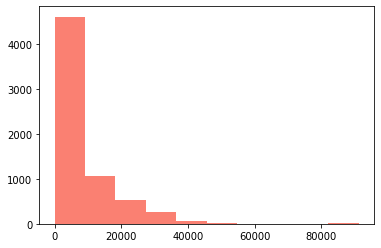

In [ ]:
#교통량['전체'] 히스토그램 확인
plt.hist(group_교통량['전체_추정교통량'], color='salmon')
plt.show()

In [ ]:
#!pip install jenkspy

In [ ]:
import jenkspy
#교통량['전체']단계구분 : 네츄럴 브레이크(5단계) 확인 -> 지도에서 등급 구분?
breaks = jenkspy.jenks_breaks(group_교통량['전체_추정교통량'], nb_class = 5)
print(breaks)
group_교통량['cut_jenks'] = pd.cut(group_교통량['전체_추정교통량'],
                                bins=breaks,
                                labels=['break_1', 'break_2', 'break_3', 'break_4', 'break_5'],
                               include_lowest=True)

단계구분_교통량 = group_교통량.groupby(['cut_jenks'], as_index=False).count()
단계구분_교통량

[1.0, 5789.5, 14075.5, 24527.5, 46085.5, 91295.0]


cut_jenks  link_id  읍면동명  도로등급  ...  혼잡시간강도  혼잡빈도강도  혼잡시간_차량  혼잡빈도_차량
0   break_1     4022  4022  4022  ...    4022    4022     4022     4022
1   break_2     1284  1284  1284  ...    1284    1284     1284     1284
2   break_3      760   760   760  ...     760     760      760      760
3   break_4      471   471   471  ...     471     471      471      471
4   break_5       31    31    31  ...      31      31       31       31

[5 rows x 13 columns]

In [ ]:
# Shapely 형태의 데이터를 받아 내부 좌표들을 List안에 반환합니다.
def line_string_to_coordinates(line_string):
    if isinstance(line_string, shapely.geometry.linestring.LineString):
        lon, lat = line_string.xy
        return [[x, y] for x, y in zip(lon, lat)]
    elif isinstance(line_string, shapely.geometry.multilinestring.MultiLineString):
        ret = []
        for i in range(len(line_string)):
            lon, lat = line_string[i].xy
            for x, y in zip(lon, lat):
                ret.append([x, y])
        return ret

In [ ]:
m_도로망 = 도로망.copy()

# m_도로망 정규화도로폭 칼럼추가
m_도로망['정규화도로폭'] = m_도로망['width'] / m_도로망['width'].max() #0~1 사이의 값으로 변환
    
# m_도로망['geometry'] -> list 안에 넣기
m_도로망['geometry'] = m_도로망['geometry'].apply(line_string_to_coordinates)
m_도로망 = pd.DataFrame(m_도로망) # geopanadas 가 아닌 pandas 의 데이터프레임으로 꼭 바꿔줘야 합니다.
m_도로망.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6653 entries, 0 to 6652
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   link_id     6653 non-null   object 
 1   max_speed   6653 non-null   float64
 2   road_name   5478 non-null   object 
 3   road_no     6653 non-null   object 
 4   road_rank   6653 non-null   object 
 5   link_type   6653 non-null   object 
 6   road_type   6653 non-null   object 
 7   facil_name  179 non-null    object 
 8   up_lanes    6653 non-null   object 
 9   dw_lanes    6653 non-null   object 
 10  oneway      6653 non-null   object 
 11  length      6653 non-null   float64
 12  width       6653 non-null   float64
 13  car_lane    6653 non-null   object 
 14  num_cross   6653 non-null   float64
 15  barrier     6653 non-null   object 
 16  up_its_id   6653 non-null   object 
 17  dw_its_id   6653 non-null   object 
 18  geometry    6653 non-null   object 
 19  정규화도로폭      6653 non-null  

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [ ]:
#지도 시각화
m_교통량 = group_교통량.merge(m_도로망, on = 'link_id')

In [ ]:
df = m_교통량
str(df.columns.tolist())

"['link_id', '읍면동명', '도로등급', '링크길이', '전체_추정교통량', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량', '혼잡시간강도', '혼잡빈도강도', '혼잡시간_차량', '혼잡빈도_차량', 'cut_jenks', 'max_speed', 'road_name', 'road_no', 'road_rank', 'link_type', 'road_type', 'facil_name', 'up_lanes', 'dw_lanes', 'oneway', 'length', 'width', 'car_lane', 'num_cross', 'barrier', 'up_its_id', 'dw_its_id', 'geometry', '정규화도로폭']"

In [ ]:
m_교통량.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6568 entries, 0 to 6567
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   link_id     6568 non-null   object  
 1   읍면동명        6568 non-null   object  
 2   도로등급        6568 non-null   float64 
 3   링크길이        6568 non-null   float64 
 4   전체_추정교통량    6568 non-null   float64 
 5   승용차_추정교통량   6568 non-null   float64 
 6   버스_추정교통량    6568 non-null   float64 
 7   화물차_추정교통량   6568 non-null   float64 
 8   혼잡시간강도      6568 non-null   float64 
 9   혼잡빈도강도      6568 non-null   float64 
 10  혼잡시간_차량     6568 non-null   float64 
 11  혼잡빈도_차량     6568 non-null   float64 
 12  cut_jenks   6568 non-null   category
 13  max_speed   6568 non-null   float64 
 14  road_name   5426 non-null   object  
 15  road_no     6568 non-null   object  
 16  road_rank   6568 non-null   object  
 17  link_type   6568 non-null   object  
 18  road_type   6568 non-null   object  
 19  facil_

In [ ]:
cols = ['link_id', '전체_추정교통량', '혼잡시간_차량', '혼잡빈도_차량', 'cut_jenks', 'link_type', 'length', 'width', 'geometry', '정규화도로폭']
df_subset = df[cols]

### df > geojson

In [ ]:
def df_to_geojson(df, properties, geometry = 'geometry'):
    # geojson 형식을 사용하여 geojson 데이터를 포함하는 새로운 파이썬 사전을 만듭니다.
    geojson = {'type':'FeatureCollection', 'features':[]}

    # 데이터 프레임의 각 행을 반복하고 각 행을 geojson 형식으로 변환
    for _, row in df.iterrows():
        # create a feature template to fill in
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{"type": "MultiLineString",
                               "coordinates":[]}}

        # 좌표를 입력
        feature['geometry']["coordinates"] = [row[geometry]]

        # 각 열에 대해 값을 가져 와서 새 feature 속성으로 추가합니다.
        for prop in properties:
            feature['properties'][prop] = row[prop]
        
        # 변환 된 데이터 프레임 행을 dict 내의 기능 목록에 추가
        geojson['features'].append(feature)
    
    return geojson


In [ ]:
#mapbox token
token = 'pk.eyJ1IjoiaWx3b29sZWUiLCJhIjoiY2tsczRpYmRkMDA2czJ3bXM1MHQ0ZWM5aSJ9.m8U8iCHkhBFTpeQ-YNtg3A'

In [ ]:
#geojson = df_subset을 geojson파일로 변환
cols = ['link_id', '전체_추정교통량', '혼잡시간_차량', '혼잡빈도_차량', 'cut_jenks', 'link_type', 'length', 'width', 'geometry', '정규화도로폭']
geojson = df_to_geojson(df_subset, cols)

In [ ]:
group_교통량.isnull().sum()

link_id      0
읍면동명         0
도로등급         0
링크길이         0
전체_추정교통량     0
승용차_추정교통량    0
버스_추정교통량     0
화물차_추정교통량    0
혼잡시간강도       0
혼잡빈도강도       0
혼잡시간_차량      0
혼잡빈도_차량      0
cut_jenks    0
dtype: int64

In [ ]:
#!pip install mapboxgl

In [ ]:
# mapbox
from mapboxgl.viz import LinestringViz
from mapboxgl.utils import create_color_stops, create_numeric_stops

#mapbox viz(전체교통량)
color_breaks = jenkspy.jenks_breaks(group_교통량['전체_추정교통량'], nb_class = 5)
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

viz = LinestringViz(geojson,
                access_token= token, 
                color_property = "전체_추정교통량",
                color_stops = color_stops,
                line_width_property='정규화도로폭',
                line_width_stops=create_numeric_stops([0, 0.2, 0.4, 0.6, 0.8, 1.0], 1, 10),
                opacity=0.8,
                center = (127.0094448,  37.275051),
                zoom = 14,
                below_layer = 'waterway-label')
viz.show()

In [ ]:
#mapbox viz(혼잡시간_차량)
color_breaks = jenkspy.jenks_breaks(group_교통량['혼잡시간_차량'], nb_class = 5)
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

viz = LinestringViz(geojson,
                access_token= token, 
                color_property = "혼잡시간_차량",
                color_stops = color_stops,
                line_width_property='정규화도로폭',
                line_width_stops=create_numeric_stops([0, 0.2, 0.4, 0.6, 0.8, 1.0], 1, 10),
                opacity=0.8,
                center = (127.0094448,  37.275051),
                zoom = 14,
                below_layer = 'waterway-label')
viz.show()

In [ ]:
주차장 = pd.read_csv(colab_path + "12.수원시_주차장현황.csv")
주차장
#주차장명    주차장의 이름
# 주차장구분    주차장 구분 정보
# 주차장유형    주차장의 유형
# 주차구획수    주차장의 최대 허용량 
# lon    경도
# lat    위도

주차장명 주차장구분 주차장유형  주차구획수         lon        lat
0     장안동공영    공영    노외    138  127.014362  37.286489
1    팔달주차타워    공영    노외    345  127.020007  37.276191
2      장다리길    공영    노상    159  127.028668  37.274683
3   화성행궁주차장    공영    노상    236  127.013193  37.281811
4    연무대주차장    공영    노상    199  127.023533  37.287658
..      ...   ...   ...    ...         ...        ...
65    농수산시장    공영    부설    596  127.030426  37.254898
66    한서주차장    민영    노외     22  127.011588  37.254956
67    동서주차장    민영    노외     11  127.030461  37.260881
68    길목주차장    민영    노외     34  127.008355  37.254675
69   디에스주차장    민영    노외     29  126.971987  37.229161

[70 rows x 6 columns]

In [ ]:
주차장.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   주차장명    70 non-null     object 
 1   주차장구분   70 non-null     object 
 2   주차장유형   70 non-null     object 
 3   주차구획수   70 non-null     int64  
 4   lon     70 non-null     float64
 5   lat     70 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.4+ KB


In [ ]:
주차장['주차장유형'].unique()

array(['노외', '노상', '부설'], dtype=object)

In [ ]:
def parking(park):
    num = 0
    if   park == '노외': num = 0
    elif park == '노상': num = 1
    else: num = 2
    return num

In [ ]:
주차장['주차장유형']=주차장['주차장유형'].apply(lambda x: parking(x)) #0 노외 1 노상 2 부설

In [ ]:
주차장['주차장구분'].unique() 

array(['공영', '민영'], dtype=object)

In [ ]:
주차장['주차장구분']=주차장['주차장구분'].apply(lambda x: 0 if x=="공영" else 1) #0 공영 1 민영

In [ ]:
주차장 = 주차장.drop("주차장명", axis=1)
주차장.head()

주차장구분  주차장유형  주차구획수         lon        lat
0      0      0    138  127.014362  37.286489
1      0      0    345  127.020007  37.276191
2      0      1    159  127.028668  37.274683
3      0      1    236  127.013193  37.281811
4      0      1    199  127.023533  37.287658

In [ ]:
대기오염 = pd.read_csv(colab_path + "11.수원시_대기오염도_측정현황.csv")
대기오염
#구분    측정 대상 대기의 구분 정보
# 측정월    측정된 월 
# 측정소    측정된 장소
# 미세먼지(㎍/㎥)    미세먼지 측정 농도
# 초미세먼지(㎍/㎥)    초미세먼지 측정 농도
# 오존(ppm)    오존 측정 농도
# 이산화질소(ppm)    이산화질소 측정 농도
# 아황산가스(ppm)    아황산가스 측정 농도
# 일산화탄소(ppm)    일산화탄소 측정 농도
# 비고    추가 정보
# lon    경도
# lat    위도

구분       측정월   측정소 미세먼지(㎍/㎥)  ... 일산화탄소(ppm)   비고         lon        lat
0    도시대기   2019.1월   고색동        62  ...        0.8  NaN  126.976384  37.252329
1    도시대기   2019.1월   광교동        64  ...        0.8  NaN  127.070615  37.291321
2    도시대기   2019.1월   신풍동        65  ...        0.8  NaN  127.010465  37.283850
3    도시대기   2019.1월   영통동        68  ...        0.9  NaN  127.056294  37.246901
4    도시대기   2019.1월   인계동        68  ...        0.9  NaN  127.028723  37.263637
..    ...       ...   ...       ...  ...        ...  ...         ...        ...
187  도시대기  2020.12월   영통동        40  ...        0.7  NaN  127.056294  37.246901
188  도시대기  2020.12월   인계동        44  ...        0.7  NaN  127.028723  37.263637
189  도시대기  2020.12월   천천동        43  ...        0.6  NaN  126.975305  37.292877
190  도시대기  2020.12월  호매실동        44  ...        0.5  NaN  126.957008  37.266153
191   도로변  2020.12월   동수원        44  ...        0.5  NaN  127.030494  37.276744

[192 rows x 12 columns]

In [ ]:
대기오염.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   구분          192 non-null    object 
 1   측정월         192 non-null    object 
 2   측정소         192 non-null    object 
 3   미세먼지(㎍/㎥)   192 non-null    object 
 4   초미세먼지(㎍/㎥)  192 non-null    object 
 5   오존(ppm)     192 non-null    object 
 6   이산화질소(ppm)  192 non-null    object 
 7   아황산가스(ppm)  192 non-null    object 
 8   일산화탄소(ppm)  192 non-null    object 
 9   비고          3 non-null      object 
 10  lon         192 non-null    float64
 11  lat         192 non-null    float64
dtypes: float64(2), object(10)
memory usage: 18.1+ KB


In [ ]:
대기오염['비고'].unique() #필요없을듯?

array([nan, '설치전(2019.4월 설치)'], dtype=object)

In [ ]:
대기오염['구분'].unique()

array(['도시대기', '도로변'], dtype=object)

In [ ]:
버스정류장 = pd.read_csv(colab_path+"1.수원시_버스정류장.csv")
버스정류장.info()
# 정류장ID    버스정류장의 ID값
# 정류장명    정류장의 이름
# 정류장유형    정류장 유형 정보
# 환승역타입    환승역 여부
# 위치(동)    정류장의 위치
# 쉘터    버스정류장의 쉘터 설치 유무(1:설치/공백:미설치)
# BIS설치여부    버스정류장의 BIS 설치 유무(1:설치/공백:미설치)
# LED    LED 전광판 설치 개수
# LCD    LCD 전광판 설치 개수
# LED+LCD복합형    LED+LCD복합형 전광판 설치 개수
# 알뜰형    알뜰형 전광판 설치 개수
# 임대형(음성)    임대형 전광판 설치 개수
# lon    경도
# lat    위도

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1179 entries, 0 to 1178
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   정류장ID       1179 non-null   int64  
 1   정류장명        1179 non-null   object 
 2   정류장유형       1179 non-null   object 
 3   환승역타입       1168 non-null   object 
 4   위치(동)       1179 non-null   object 
 5   쉘터          781 non-null    float64
 6   BIS설치여부     928 non-null    float64
 7   LED         378 non-null    float64
 8   LCD         166 non-null    float64
 9   LED+LCD복합형  358 non-null    float64
 10  알뜰형         26 non-null     float64
 11  임대형(음성)     0 non-null      float64
 12  lon         1179 non-null   float64
 13  lat         1179 non-null   float64
dtypes: float64(9), int64(1), object(4)
memory usage: 129.1+ KB


In [ ]:
버스정류장['정류장유형'].unique()

array(['시내,마을', '시내', '시내,시외', '시내,마을,시외', '시내,공항', '시내,시외,공항',
       '시내,마을,공항'], dtype=object)

In [ ]:
버스정류장.head()

정류장ID     정류장명  정류장유형 환승역타입  ...  알뜰형  임대형(음성)         lon        lat
0  201000313     권선구청  시내,마을    일반  ...  NaN      NaN  126.970983  37.256983
1  201000344    중보들공원  시내,마을    일반  ...  NaN      NaN  126.991029  37.244605
2  201000345  남수원초등학교     시내    일반  ...  1.0      NaN  127.016000  37.251091
3  201000379   신미주아파트     시내    일반  ...  NaN      NaN  126.953845  37.268806
4  201000055   농수산물시장     시내    일반  ...  NaN      NaN  127.029815  37.256755

[5 rows x 14 columns]

In [ ]:
sub_버스정류장 = 버스정류장[["정류장ID", "정류장명", "lon", "lat"]]
sub_버스정류장.head()

정류장ID     정류장명         lon        lat
0  201000313     권선구청  126.970983  37.256983
1  201000344    중보들공원  126.991029  37.244605
2  201000345  남수원초등학교  127.016000  37.251091
3  201000379   신미주아파트  126.953845  37.268806
4  201000055   농수산물시장  127.029815  37.256755

In [ ]:
sub_대기오염 = 대기오염[["측정월", "측정소", "미세먼지(㎍/㎥)", "초미세먼지(㎍/㎥)", "lon", "lat"]]
sub_대기오염

측정월   측정소 미세먼지(㎍/㎥) 초미세먼지(㎍/㎥)         lon        lat
0     2019.1월   고색동        62         41  126.976384  37.252329
1     2019.1월   광교동        64         36  127.070615  37.291321
2     2019.1월   신풍동        65         40  127.010465  37.283850
3     2019.1월   영통동        68         23  127.056294  37.246901
4     2019.1월   인계동        68         42  127.028723  37.263637
..        ...   ...       ...        ...         ...        ...
187  2020.12월   영통동        40         24  127.056294  37.246901
188  2020.12월   인계동        44         28  127.028723  37.263637
189  2020.12월   천천동        43         26  126.975305  37.292877
190  2020.12월  호매실동        44         27  126.957008  37.266153
191  2020.12월   동수원        44         29  127.030494  37.276744

[192 rows x 6 columns]

In [ ]:
#교통량_전일, 혼잡시간강도_전일, 혼잡빈도강도_전일 병합(merge)
merge_대기오염 = sub_대기오염.merge(sub_버스정류장,on=['lon', 'lat'],how="outer")
merge_대기오염.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1371 entries, 0 to 1370
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   측정월         192 non-null    object 
 1   측정소         192 non-null    object 
 2   미세먼지(㎍/㎥)   192 non-null    object 
 3   초미세먼지(㎍/㎥)  192 non-null    object 
 4   lon         1371 non-null   float64
 5   lat         1371 non-null   float64
 6   정류장ID       1179 non-null   float64
 7   정류장명        1179 non-null   object 
dtypes: float64(3), object(5)
memory usage: 96.4+ KB


In [ ]:
merge_대기오염.head(100)

측정월  측정소 미세먼지(㎍/㎥) 초미세먼지(㎍/㎥)         lon        lat  정류장ID 정류장명
0    2019.1월  고색동        62         41  126.976384  37.252329    NaN  NaN
1    2019.2월  고색동        55         36  126.976384  37.252329    NaN  NaN
2    2019.3월  고색동        66         47  126.976384  37.252329    NaN  NaN
3    2019.4월  고색동        36         19  126.976384  37.252329    NaN  NaN
4    2019.5월  고색동        43         25  126.976384  37.252329    NaN  NaN
..       ...  ...       ...        ...         ...        ...    ...  ...
95  2020.12월  영통동        40         24  127.056294  37.246901    NaN  NaN
96   2019.1월  인계동        68         42  127.028723  37.263637    NaN  NaN
97   2019.2월  인계동        58         38  127.028723  37.263637    NaN  NaN
98   2019.3월  인계동        71         50  127.028723  37.263637    NaN  NaN
99   2019.4월  인계동        41         21  127.028723  37.263637    NaN  NaN

[100 rows x 8 columns]

In [ ]:
#!pip install pydeck

In [ ]:
import pydeck as pdk

In [ ]:
layer = pdk.Layer(
    'HeatmapLayer',
    merge_대기오염,
    get_position='[lon, lat]'
)

center = [127.0094448,  37.275051]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    zoom=10)

r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{"initialViewState": {"lat…

### 최적화 모델 : Maximal Covering Location Problem (MCLP)
- 정의: MCLP는 최대지역커버문제로, 설비가 커버하는 수요 (covered demand)의 합을 최대화 하면서 주어진 K개의 설비를 세울 위치를 선정하는 문제

- 가정

설비의 위치가 수요 발생 지점으로부터 일정 거리 Residual 이내에 수요를 커버함.
이때 거리 Residual은 커버리지 거리(covered distance) 라고 함.
커버되지 못한 수여는 서비스를 받지 못하는 수요가 아니라 서비스를 받긴 하지만 서비스 받는 설비로 부터의 거리가 커버리지 밖에 있어 만족할 만한 서비스 수준을 제공받지 못하는 수요를 의미
- Mathematical statement
  - i : 수요 포인트 index
  - j : 설비 후보지역 index
  - I : 수요 포인트 집합
  - J : 설비 후보지역 집합
  - K : 총 설치해야 하는 설비 개수
  - x : 설비 후보 지역 중 위치 j에 설비가 설치되면 1, 그렇지 않으면 0
  - y : 적어도 하나의 설비로 그 포인트가 커버가 되면 1, 그렇지 않으면 0
Formulation
\begin{align} &\text{maximize} \sum_{i\in I} w_i y_i ...(1) \ \text{s.t.} \quad & y_i \le \sum_{j\in N_i}x_j \qquad for \quad all \quad i\in I ... (2)\ &\sum_{j\in J}x_j = K ... (3)\ &x_j, y_i \in {0,1} \qquad for \quad all \quad i\in I,j\in J \end{align}
-(1) : 목적함수, 가중치 w인 수요 포인트를 최대한 많이 커버하게 해라
-(2) : 수요포인트 i는 설비 후보 지역이 커버하는 거리안에서 적어도 하나 이상의 설비로 부터 커버가 된다. 
-(3) : 총 설치할 설비는 K개 이다.

In [ ]:
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])




def generate_candidate_sites(df_result_fin,M=100):
    from shapely.geometry import Polygon, Point
    sites = []
    idx=np.random.choice(np.array(range(0,len(df_result_fin))), M)
    for i in range(len(idx)):
        random_point = Point(np.array(df_result_fin.iloc[idx]['coord_cent'])[i][0],
                             np.array(df_result_fin.iloc[idx]['coord_cent'])[i][1])
        sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def generate_candidate_sites(df_result_fin,Weight,M=100):
    sites = []
    idx = df_result_fin.sort_values(by = Weight, ascending = False).iloc[1:M].index
    for i in range(len(idx)):
        random_point = Point(np.array(df_result_fin.loc[idx]['coord_cent'])[i][0],
                             np.array(df_result_fin.loc[idx]['coord_cent'])[i][1])
        sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])



from scipy.spatial import distance_matrix
def mclp(points,K,radius,M,df_result_fin,w,Weight):

    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(df_result_fin,Weight,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0

    from mip import Model, xsum, maximize, BINARY

    # Build model
    m = Model("mclp")
    # Add variables

    x = [m.add_var(name = "x%d" % j, var_type = BINARY) for j in range(J)]
    y = [m.add_var(name = "y%d" % i, var_type = BINARY) for i in range(I)]


    m.objective = maximize(xsum(w[i]*y[i] for i in range (I)))

    m += xsum(x[j] for j in range(J)) == K

    for i in range(I):
        m += xsum(x[j] for j in np.where(D[i]==1)[0]) >= y[i]

    m.optimize()
    
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objective_value)

    solution = []
    for i in range(J):
        if x[i].x ==1:
            solution.append(int(x[i].name[1:]))
    opt_sites = sites[solution]
            
    return opt_sites,m.objective_value

In [ ]:
버스정류장

정류장ID     정류장명  정류장유형 환승역타입  ...  알뜰형  임대형(음성)         lon        lat
0     201000313     권선구청  시내,마을    일반  ...  NaN      NaN  126.970983  37.256983
1     201000344    중보들공원  시내,마을    일반  ...  NaN      NaN  126.991029  37.244605
2     201000345  남수원초등학교     시내    일반  ...  1.0      NaN  127.016000  37.251091
3     201000379   신미주아파트     시내    일반  ...  NaN      NaN  126.953845  37.268806
4     201000055   농수산물시장     시내    일반  ...  NaN      NaN  127.029815  37.256755
...         ...      ...    ...   ...  ...  ...      ...         ...        ...
1174  201000266   구운초등학교     시내    일반  ...  NaN      NaN  126.978712  37.281431
1175  228000723    경희대정문  시내,마을    일반  ...  NaN      NaN  127.077907  37.247475
1176  233001574   수영리검사소  시내,마을    일반  ...  NaN      NaN  126.968503  37.232512
1177  201000123     자혜학교     시내    일반  ...  NaN      NaN  126.977880  37.265151
1178  233001986   수영리검사소  시내,마을    일반  ...  NaN      NaN  126.968669  37.232706

[1179 rows x 14 columns]

### 필요없는 데이터
- 요일별, 지적도, 주차장현황
### 우선 조건
0. BIS: 전기/통신 가능 (태양광 설치용량- 쉘터 가동 대비 부족하므로 현실적인 어려움. cf. 쉘터 상단(6mx2.5m 기본형)에 태양광 패널을 설치해 하루 일조량 4시간 기준으로 생산 전력량은 12.6Kw 출처 : 국토일보(http://www.ikld.kr))
0. 가능한 기존입지 손대지 말기 + 도로보행공간 확보 (5.5m + 4.0m)
1. 대기오염
2. 다양한 정보제공 -> 유동인구 (승하차) + 인구정보(생산가능)

- 버스 승하차 top 정류장, 노선 (가장 많이 겹치는 정류장) --> 승하차 시간대(2-3개 정도만 보여주기)/ 상업지구인지 아닌지, 승하차 인원

*버스정류장(승하차/노선도) -> 환승, 탑승수, 버스수, 상업/주거 --> 최대 최소 평균 편차(describe) / 이상기후 제외(눈, 비 등등) + 휴일제외(설날,추석 등등)